In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gibbs_sampling import *
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC

In [15]:
df = pd.read_csv('Data/macro1.csv')
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.0,5.0,5.000,5.000000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0,6.0,1.0
1,01/01/1959,2289.8,2151.9,18.191,253747.578885,18234.44037,21.9289,21.5499,20.9407,28.4830,...,12.133,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2,NaN
2,02/01/1959,2299.6,2160.2,18.380,255653.461901,18368.21974,22.3584,21.8408,21.1221,28.6919,...,12.149,2.13,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5,NaN
3,03/01/1959,2314.4,2176.1,18.555,254743.765035,18521.70306,22.6805,21.9730,21.2257,28.6919,...,12.169,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6,NaN
4,04/01/1959,2328.5,2190.3,18.488,259878.438046,18533.11060,23.1636,22.2903,21.5367,29.1445,...,12.211,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8,NaN


In [16]:
# We remove the first row
df = df.iloc[1:]

In [18]:
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
1,01/01/1959,2289.8,2151.9,18.191,253747.578885,18234.44037,21.9289,21.5499,20.9407,28.4830,...,12.133,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2,NaN
2,02/01/1959,2299.6,2160.2,18.380,255653.461901,18368.21974,22.3584,21.8408,21.1221,28.6919,...,12.149,2.13,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5,NaN
3,03/01/1959,2314.4,2176.1,18.555,254743.765035,18521.70306,22.6805,21.9730,21.2257,28.6919,...,12.169,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6,NaN
4,04/01/1959,2328.5,2190.3,18.488,259878.438046,18533.11060,23.1636,22.2903,21.5367,29.1445,...,12.211,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8,NaN
5,05/01/1959,2342.5,2205.6,18.710,261691.222172,18678.29753,23.5125,22.4754,21.7441,29.2838,...,12.230,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7,NaN


In [19]:
# We remove the features in which there are a lot of Nan values
pd.DataFrame(df.isna().sum()).sort_values(0, ascending=False).iloc[:10]

,0
ACOGNO,398
TWEXMMTH,168
UMCSENTx,154
ANDENOx,109
VXOCLSx,42
PERMITW,12
PERMITS,12
PERMITMW,12
PERMITNE,12
PERMIT,12


In [20]:
columns_to_drop = ['ACOGNO', 'TWEXMMTH', 'UMCSENTx', 'ANDENOx', 'VXOCLSx']
df = df.drop(columns_to_drop,axis=1)

In [21]:
# We remove the remaining NaN values
df = df.dropna()

In [24]:
#We reorder the columns
columns = df.columns.tolist()
new_column_order = ['INDPRO'] + [column for column in columns if column not in ['sasdate', 'INDPRO']]
df = df[new_column_order]

In [25]:
df.head()

,INDPRO,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
13,24.1298,2391.2,2252.3,18.910,263212.787497,18762.29853,23.3215,22.6512,30.5722,20.1768,...,54.611,20.000,12.502,2.22,2.57,2.13,286.7,7362.0,14063.0,75.5
14,23.9151,2392.8,2253.8,18.993,267039.890455,18831.78084,23.1893,22.5734,30.2240,19.8991,...,54.700,20.001,12.522,2.23,2.59,2.14,287.0,7396.0,14144.0,73.3
15,23.7004,2397.2,2255.4,19.262,259610.179810,18811.03986,23.1100,22.5475,30.2588,19.5057,...,54.540,20.037,12.529,2.24,2.69,2.14,287.8,7456.0,14239.0,71.5
16,23.5125,2405.6,2263.4,19.560,262179.545533,19304.67539,23.1629,22.5734,30.4677,19.4826,...,54.606,20.163,12.555,2.24,2.61,2.14,288.3,7582.0,14413.0,71.5
17,23.4857,2411.7,2269.4,19.166,254056.886617,19016.37565,23.2951,22.7289,30.6418,19.6677,...,54.600,20.154,12.590,2.24,2.64,2.14,289.1,7673.0,14559.0,71.7


In [28]:
num_predictors = len(df.columns) - 1
num_predictors

120

In [29]:
# We initialize the parameters for the Gibbs
a, b, A, B = 1, 1, 1, 1 # Parameters for Beta laws
q = np.random.beta(a, b, 1)[0]
R_2 = np.random.beta(A, B, 1)[0]

start = np.arange(0, 0.1 + 0.001, 0.001)[1:]
mid = np.arange(0.11, 0.9 + 0.01, 0.01)
end = np.arange(0.901, 1 + 0.001, 0.001)[:-1]
support = np.concatenate((start, mid, end))

In [30]:
# We define the outcome y and the predictors X
X = df.drop(['INDPRO'], axis=1)
y = df['INDPRO']

C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+01, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+01, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

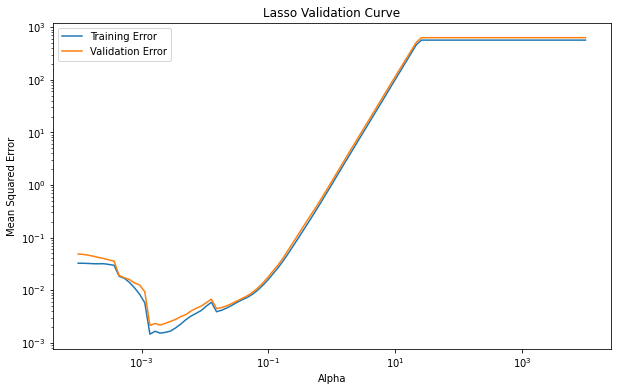

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)
alphas = np.logspace(-4, 4, 100)
train_errors = []
validation_errors = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha,max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)  # Supposons que X_train et y_train soient vos données d'entraînement
    y_pred_train = lasso_model.predict(X_train_scaled)
    y_pred_validation = lasso_model.predict(X_test_scaled)  # Supposons que X_validation soit votre ensemble de validation
    
    train_errors.append(mean_squared_error(y_train, y_pred_train))  # Vous pouvez utiliser une autre métrique de performance
    validation_errors.append(mean_squared_error(y_test, y_pred_validation))

# Tracer la courbe de validation
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Training Error')
plt.plot(alphas, validation_errors, label='Validation Error')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')  # Utilisez la métrique de performance appropriée
plt.legend()
plt.title('Lasso Validation Curve')
plt.show()

#$\alpha _{opt}$ = 0.005 : (Train Error , Validation Error) = (0.33548518219396917, 0.32653694179816917)

In [85]:
# Now, we run the Lasso Regression using our best regularization term.
lasso_model = Lasso(alpha=0.005)
lasso_model.fit(X_train_scaled, y_train)
beta_estimates = lasso_model.coef_

C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+02, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(


In [86]:
y_pred_train = lasso_model.predict(X_train_scaled)
y_pred_validation = lasso_model.predict(X_test_scaled)  # Supposons que X_validation soit votre ensemble de validation
train_error = mean_squared_error(y_train, y_pred_train)
validation_error = mean_squared_error(y_test, y_pred_validation)

In [87]:
train_error , validation_error

(0.12371893270533105, 0.13578030507949632)

In [88]:
z_initial = (np.abs(beta_estimates) > 0).astype(int)

In [89]:
z_initial.sum()

50

In [91]:
np.linalg.norm(beta_estimates,ord=1)

47.05484454289537

In [96]:
z_final = sample_z(Y=y, X=X_scaled, q_start=q, R_2_start=R_2, num_iterations=5, z=z_initial, support=support)

c:\Users\bapti\OneDrive\Bureau\GitHub\bayesian_statistics_project\gibbs_sampling.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: density_R2(x, z), 10**(-3), r)[0]/quad(lambda x: density_R2(x, z), 10**(-3), 1 - 10**(-3))[0]
c:\Users\bapti\OneDrive\Bureau\GitHub\bayesian_statistics_project\gibbs_sampling.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  p = 1 / (1 + ( ((gamma_2**0.5)*(1-q)) / q ) * (np.linalg.det(W_tilde_inv_0)/np.linalg.det(W_tilde_inv))**(0.5)
c:\Users\bapti\OneDrive\Bureau\GitHub\bayesian_statistics_project\gibbs_sam

In [97]:
z_final.sum()

57

In [ ]:
from statistics import median
median_q_dataset_of_dataset = []
R_y_list = [0.05, 0.25, 0.5]
comptage = 4

for R_y in R_y_list :
    median_q_dataset = []
    for i in range(100):
        start = time.time()
        median_q_dataset.append(np.median(generate_dataset(10, R_y)))
        end = time.time()
        print("Time of execution =",((end-start)//60), "m", (((end-start)%60)//1), "; s=", 10, " Ry=", R_y, " iteration:", i)
    file_name = 'list_of_median_' + str(comptage) +'.csv'
    pd.DataFrame(np.array(median_q_dataset)).to_csv(file_name)
    median_q_dataset_of_dataset.append(median_q_dataset)
    comptage += 1